## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.shape

(2218, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

In [6]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [7]:
#counts of response variable values
df.state.value_counts()

state
isolated    1791
released     307
deceased      32
Name: count, dtype: int64

In [8]:
df['birth_year'].isnull().sum()

454

In [9]:
df['birth_year'].value_counts()

birth_year
1969.0    54
1995.0    51
1998.0    47
1996.0    45
1999.0    45
          ..
1928.0     2
1927.0     2
1925.0     1
1916.0     1
1931.0     1
Name: count, Length: 96, dtype: int64

In [10]:
birth_mean = df['birth_year'].mean()

print(birth_mean)

1974.9886621315193


In [11]:
df['birth_year'].describe()

count    1764.000000
mean     1974.988662
std        19.412643
min      1916.000000
25%      1962.000000
50%      1974.500000
75%      1993.000000
max      2020.000000
Name: birth_year, dtype: float64

In [12]:
print(2020-birth_mean)

45.01133786848072


In [13]:
#Group by birth_year
grouped_by = df['birth_year'].value_counts().sort_index()

In [14]:
# Create a copy of df 
df2 = df 

In [15]:
bins= [1910, 1930, 1950, 1960,1980,2000, 2020]


#  Use pd.cut() to bin the birth_year into specified ranges

#df2['birth_year_bins'] = pd.cut(df['birth_year'], bins=bins)

#Calculate the count of each bin
#grouped_by_bins = df2['birth_year_bins'].value_counts().sort_index()


#sns.barplot(x=grouped_by_bins.index.astype(str), y=grouped_by_bins.values)

#Set labels and title
#plt.xlabel('Birth Year Bins')
#plt.ylabel('Count')
#plt.title('Count of Birth Years in Bins')

#Rotate xticks for better readability 

#plt.xticks(rotation= 90)
# Show the plot
#plt.show()


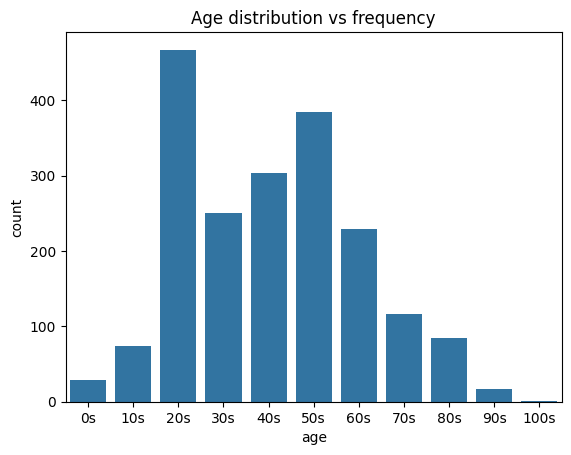

In [16]:
#Barplot to get a sense of age distribution 

age_count = df['age'].value_counts().sort_index()

Order = ['0s','10s','20s','30s','40s','50s','60s','70s','80s','90s','100s']

age_counts_order = age_count[age_count.index.isin(Order)]

sns.barplot(x=age_counts_order.index, y=age_counts_order.values, order=Order)

plt.xlabel('age')

plt.ylabel('count')

plt.title('Age distribution vs frequency')

plt.show()

In [17]:
df['age'].value_counts()

age
20s     467
50s     385
40s     303
30s     251
60s     229
70s     117
80s      84
10s      74
0s       29
90s      17
100s      1
Name: count, dtype: int64

In [18]:
df['age'].isna().sum()

261

# Comment: I want to impute the missing values of 'age' based on its distribution but I need the current values of age to try and fill in missing 'birth_year' values. 

In [19]:
#Impute missing values based on distribution of 'age' data.




In [20]:
#Groupby to get average birth_year by 'age' category 
mean_birth_years = df.groupby('age')['birth_year'].mean()

In [21]:
# Group by 'age' and calculate mean 'birth_year' for each group
mean_birth_years = df.groupby('age')['birth_year'].transform('mean')

# Fill NaN values in 'birth_year' with the corresponding age group mean
df['birth_year'] = df['birth_year'].fillna(mean_birth_years)

In [22]:
df['birth_year'].isna().sum()

151

# Possible bug!

# Here I am going to impute the missing values of 'birth_year' based on its distribution.

# This could cause errors later on or not since less than 10% of our values of 'birth_year' will be affected by this imputation. 

In [23]:
#Here I drop the null values in 'birth_year' column to get its distribution and use it with np.random.choice()

non_null_birth_year = df['birth_year'].dropna()

In [24]:
#Imputation logic. lambda searches for missing values in df['birth_year'] and replaces null values with a random birth_year from 'birth_year' column. 

#I chose this method to maintain the distribution of the 'birth_year' data

df['birth_year'] = df['birth_year'].apply(lambda x: np.random.choice(non_null_birth_year) if pd.isnull(x) else x)

In [25]:
df.isna().sum()

patient_id               0
global_num             904
sex                    145
birth_year               0
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
dtype: int64

In [26]:
df['birth_year'].head()

0    1964.0
1    1987.0
2    1964.0
3    1991.0
4    1992.0
Name: birth_year, dtype: float64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [27]:
#n_age will be created using 2020 - birth year

df['n_age'] = (2020 - df['birth_year'])

In [28]:
df['n_age'].head(10)

0    56.0
1    33.0
2    56.0
3    29.0
4    28.0
5    54.0
6    25.0
7    28.0
8    37.0
9    60.0
Name: n_age, dtype: float64

In [29]:
#Sanity check to make sure that n_age is a float
df['n_age'].dtypes

dtype('float64')

In [30]:
#Checking min value of n_age
df['n_age'].min()

0.0

In [31]:
#Max value of n_age
df['n_age'].max()

104.0

In [32]:
df['n_age'].mean()

44.80875827201907

In [33]:
#Value counts of n_age
df['n_age'].value_counts()

n_age
24.123711     86
54.159021     64
51.000000     56
25.000000     56
21.000000     52
              ..
10.000000      2
95.000000      1
104.000000     1
89.000000      1
91.625000      1
Name: count, Length: 105, dtype: int64

In [34]:
df['n_age'].isnull().sum()

0

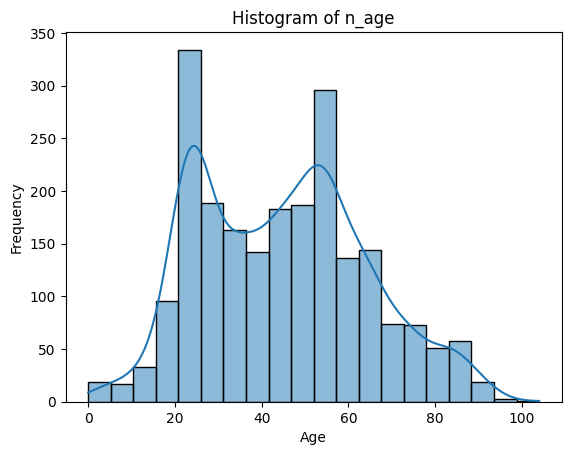

In [35]:
# Plot a histogram of the n_age column
sns.histplot(df['n_age'], bins=20, kde=True)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of n_age')

# Show the plot
plt.show()


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [36]:
#Using .isnull().sum() to print the number of missing values by column
df.isnull().sum()

patient_id               0
global_num             904
sex                    145
birth_year               0
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          2218 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

In [38]:
df['disease'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: disease, dtype: object

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [39]:
#Preserving original data set in case I need it later

df['disease'] = df['disease'].fillna(0)


In [40]:
df['disease'].head()

0    0
1    0
2    0
3    0
4    0
Name: disease, dtype: object

In [41]:
df['disease'] = df['disease'].replace({True:1})

/var/folders/yw/y4pg_jgd1337cpj1cjwrm82c0000gn/T/ipykernel_65977/963105258.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['disease'] = df['disease'].replace({True:1})


In [42]:
df['disease'].value_counts()

disease
0    2199
1      19
Name: count, dtype: int64

In [43]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,28.0


In [44]:
df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'symptom_onset_date', 'confirmed_date',
       'released_date', 'deceased_date', 'state', 'n_age'],
      dtype='object')

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [45]:
cols_to_fill = ['global_num','birth_year','infection_order','infected_by', 'contact_number']
df[cols_to_fill] = df[cols_to_fill].apply(lambda x: x.fillna(x.mean()))

In [46]:
df[cols_to_fill].isna().sum()

global_num         0
birth_year         0
infection_order    0
infected_by        0
contact_number     0
dtype: int64

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [47]:
df.isna().sum()

patient_id               0
global_num               0
sex                    145
birth_year               0
age                    261
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
dtype: int64

 **<font color='teal'> Check for any remaining null values.</font>**

In [48]:
# sex , age , city , infection_case , symptom_onset_date,  confirmed_date, released_date, deceased_date , state , n_age 
df['sex'].value_counts()


sex
female    1171
male       902
Name: count, dtype: int64

In [49]:
df['sex'].isna().sum()

145

## Comment: As of 2024 49.91% of the population in South Korea is male. Which means that this should be closely refected in our sample of over 2,0000 covid patients. 

## As it stands right now in our data set 902 males only make up 43% of the sample population. There are 145 Null values for sex, if I assign all of these as Male then total sample population will be 2,218 and the percent of males will be 47% which is closer to the population mean of 49.91%. 

In [50]:
#Assigning all null values in sex column as 'Male' to get closer to population mean of 49.9% males

df['sex'] = df['sex'].fillna('male')

In [51]:
#No null values in sex column 
df.isna().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
age                    261
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
dtype: int64

In [52]:
#age , city , infection_case , symptom_onset_date,  confirmed_date, released_date, deceased_date , state , n_age 

df['age'].value_counts()

age
20s     467
50s     385
40s     303
30s     251
60s     229
70s     117
80s      84
10s      74
0s       29
90s      17
100s      1
Name: count, dtype: int64

In [53]:
#Rounding 'n_age' 

df['n_age'] = df['n_age'].round()

In [54]:
df['n_age'].value_counts()

n_age
24.0     132
54.0      98
45.0      78
35.0      76
64.0      63
        ... 
1.0        2
94.0       2
95.0       1
104.0      1
89.0       1
Name: count, Length: 96, dtype: int64

In [55]:
df['age'].isna().sum()

261

In [56]:
df['age'].dtypes

dtype('O')

In [57]:
#Drop 'age' null values
non_null_age = df['age'].dropna()

In [58]:
#Imputation logic. lambda searches for missing values in df['age'] and replaces null values with a random age from 'age' column. 

#I chose this method to maintain the distribution of the 'age' data

df['age'] = df['age'].apply(lambda x: np.random.choice(non_null_age) if pd.isnull(x) else x)

In [59]:
df['age'].value_counts()

age
20s     528
50s     437
40s     347
30s     281
60s     262
70s     133
80s      93
10s      81
0s       35
90s      20
100s      1
Name: count, dtype: int64

In [60]:
df['age'].isna().sum()

0

In [61]:
df.isna().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
age                      0
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
dtype: int64

# Impute 'city'

In [62]:
df['city'].value_counts()

city
Gyeongsan-si     535
Cheonan-si        98
Seongnam-si       89
Bonghwa-gun       60
Gumi-si           59
                ... 
Anseong-si         1
pocheon-si         1
Hanam-si           1
Yeongyang-gun      1
Gimje-si           1
Name: count, Length: 134, dtype: int64

In [63]:
#Drop 'city' null values
non_null_city = df['city'].dropna()

In [64]:
#Imputation logic. lambda searches for missing values in df['city'] and replaces null values with a random age from 'city' column. 

#I chose this method to maintain the distribution of the 'city' data

df['city'] = df['city'].apply(lambda x: np.random.choice(non_null_city) if pd.isnull(x) else x)

In [65]:
df['city'].value_counts()

city
Gyeongsan-si       555
Cheonan-si         101
Seongnam-si         90
Bonghwa-gun         61
Gumi-si             59
                  ... 
Hanam-si             1
Taebaek-si           1
Yeosu-si             1
Dalseong-gun         1
Jeungpyeong-gun      1
Name: count, Length: 134, dtype: int64

In [66]:
df.isna().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
dtype: int64

In [67]:
df['infection_case'].value_counts()

infection_case
contact with patient                530
etc                                 220
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
River of Grace Community Church       1
Pilgrimage to Israel                  1
Name: count, dtype: int64

In [68]:
#Drop 'city' null values
non_null_inf_case = df['infection_case'].dropna()

In [69]:
#Imputation logic. lambda searches for missing values in df['infection_case'] and replaces null values with a random value from 'infection_case' column. 

#I chose this method to maintain the distribution of the 'infection_case' data since np.random.choice() is being applied it ensures that for the most part the data maintains its original distribution based on sample distribution of non null values

df['infection_case'] = df['infection_case'].apply(lambda x: np.random.choice(non_null_inf_case) if pd.isnull(x) else x)

In [70]:
df['infection_case'].value_counts()

infection_case
contact with patient                1024
etc                                  419
Guro-gu Call Center                  195
Shincheonji Church                   162
overseas inflow                      117
Onchun Church                         59
gym facility in Cheonan               57
Cheongdo Daenam Hospital              43
Ministry of Oceans and Fisheries      41
Eunpyeong St. Mary's Hospital         30
Dongan Church                         30
Seongdong-gu APT                      25
gym facility in Sejong                 6
Suyeong-gu Kindergarten                5
River of Grace Community Church        3
Pilgrimage to Israel                   2
Name: count, dtype: int64

In [71]:
#No more null values for 'infection_case' column. 

df['infection_case'].isna().sum()

0

In [72]:
df.isna().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                    0
dtype: int64

In [73]:
df['state'].value_counts()

state
isolated    1791
released     307
deceased      32
Name: count, dtype: int64

In [74]:
#Drop 'state' null values
non_null_inf_state = df['state'].dropna()

In [75]:
#Imputation logic. lambda searches for missing values in df['state'] and replaces null values with a random value from 'state' column. 

#I chose this method to maintain the distribution of the 'state' data since np.random.choice() is being applied it ensures that for the most part the data maintains its original distribution based on sample distribution of non null values

df['state'] = df['state'].apply(lambda x: np.random.choice(non_null_inf_state) if pd.isnull(x) else x)

In [76]:
df['state'].value_counts()

state
isolated    1862
released     324
deceased      32
Name: count, dtype: int64

In [77]:
df.isna().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                    0
n_age                    0
dtype: int64

Remove date columns from the data.


In [78]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [79]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   2
birth_year          105
age                  11
country               4
province             17
city                134
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 3
n_age                96
dtype: int64


Review the percent of unique values by column.

In [80]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.000902
birth_year         0.047340
age                0.004959
country            0.001803
province           0.007665
city               0.060415
disease            0.000902
infection_case     0.007214
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001353
n_age              0.043282
dtype: float64


Review the range of values per column.

In [81]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.975191e+03,1.938679e+01,1.916000e+03,1.962000e+03,1.975323e+03,1.993000e+03,2.020000e+03
disease,2218.0,8.566276e-03,9.217769e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.481019e+01,1.938096e+01,0.000000e+00,2.700000e+01,4.500000e+01,5.800000e+01,1.040000e+02


### Check for duplicated rows

In [82]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [83]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,17
4,city,134
5,infection_case,16
6,state,3


In [84]:
df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'state', 'n_age'],
      dtype='object')

In [85]:
df['infection_case'].value_counts()

infection_case
contact with patient                1024
etc                                  419
Guro-gu Call Center                  195
Shincheonji Church                   162
overseas inflow                      117
Onchun Church                         59
gym facility in Cheonan               57
Cheongdo Daenam Hospital              43
Ministry of Oceans and Fisheries      41
Eunpyeong St. Mary's Hospital         30
Dongan Church                         30
Seongdong-gu APT                      25
gym facility in Sejong                 6
Suyeong-gu Kindergarten                5
River of Grace Community Church        3
Pilgrimage to Israel                   2
Name: count, dtype: int64

**<font color='teal'> Plot the correlation heat map for the features.</font>**

In [86]:
# Dtypes

df.dtypes

patient_id           int64
global_num         float64
sex                 object
birth_year         float64
age                 object
country             object
province            object
city                object
disease              int64
infection_case      object
infection_order    float64
infected_by        float64
contact_number     float64
state               object
n_age              float64
dtype: object

In [87]:
# Subsetting numerical features for heat map


df_num_features = df[['patient_id','global_num','birth_year', 'disease', 'infection_order', 'infected_by', 'contact_number','n_age']]

In [88]:
df_num_corr = df_num_features.corr()

print(df_num_corr)

                 patient_id  global_num  birth_year       disease  \
patient_id         1.000000   -0.115774   -0.045050 -3.822030e-02   
global_num        -0.115774    1.000000   -0.003351 -1.088897e-01   
birth_year        -0.045050   -0.003351    1.000000 -1.036832e-01   
disease           -0.038220   -0.108890   -0.103683  1.000000e+00   
infection_order   -0.027281   -0.014964   -0.061465  3.781665e-16   
infected_by        0.296321   -0.052654    0.030269 -1.608674e-16   
contact_number    -0.046090   -0.042895    0.002356 -1.374432e-17   
n_age              0.044675    0.003257   -0.999992  1.036714e-01   

                 infection_order   infected_by  contact_number     n_age  
patient_id         -2.728051e-02  2.963213e-01   -4.609026e-02  0.044675  
global_num         -1.496382e-02 -5.265407e-02   -4.289483e-02  0.003257  
birth_year         -6.146531e-02  3.026878e-02    2.355678e-03 -0.999992  
disease             3.781665e-16 -1.608674e-16   -1.374432e-17  0.103671  
inf

In [89]:
df_num_corr.columns

Index(['patient_id', 'global_num', 'birth_year', 'disease', 'infection_order',
       'infected_by', 'contact_number', 'n_age'],
      dtype='object')

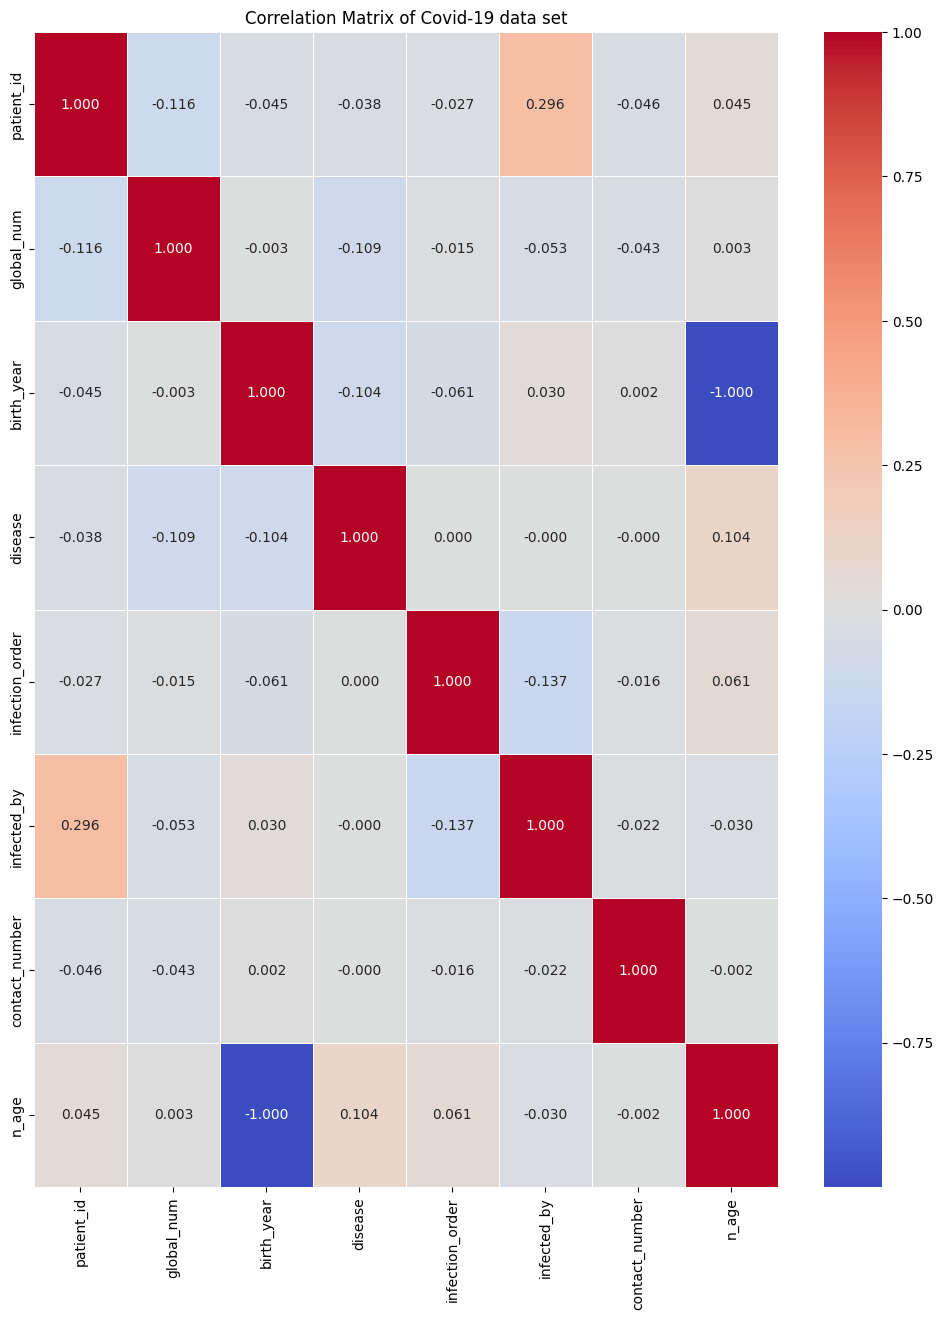

In [90]:
#Plotting df_num_corr

plt.figure(figsize=(12,15))

sns.heatmap(df_num_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.3f')

plt.title('Correlation Matrix of Covid-19 data set')

plt.show()

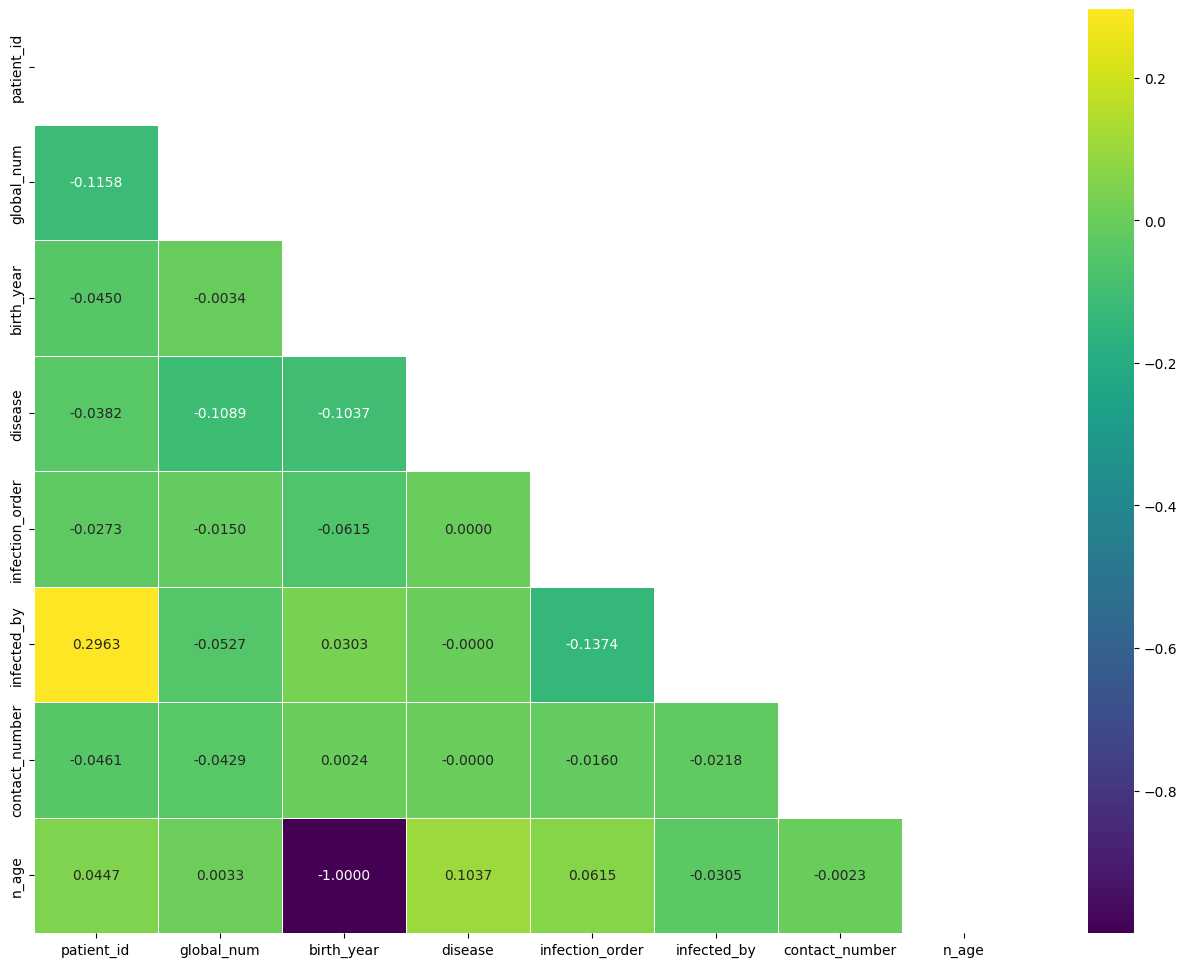

In [107]:
plt.figure(figsize=(16,12))

#Mask to truncate heatmap to reduce reduncancy of data visulaization. 
mask = np.triu(np.ones_like(df_num_corr, dtype=bool))

sns.heatmap(df_num_corr, annot=True, cmap='viridis', linewidths=0.5, mask=mask, fmt='.4f')


plt.show()

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

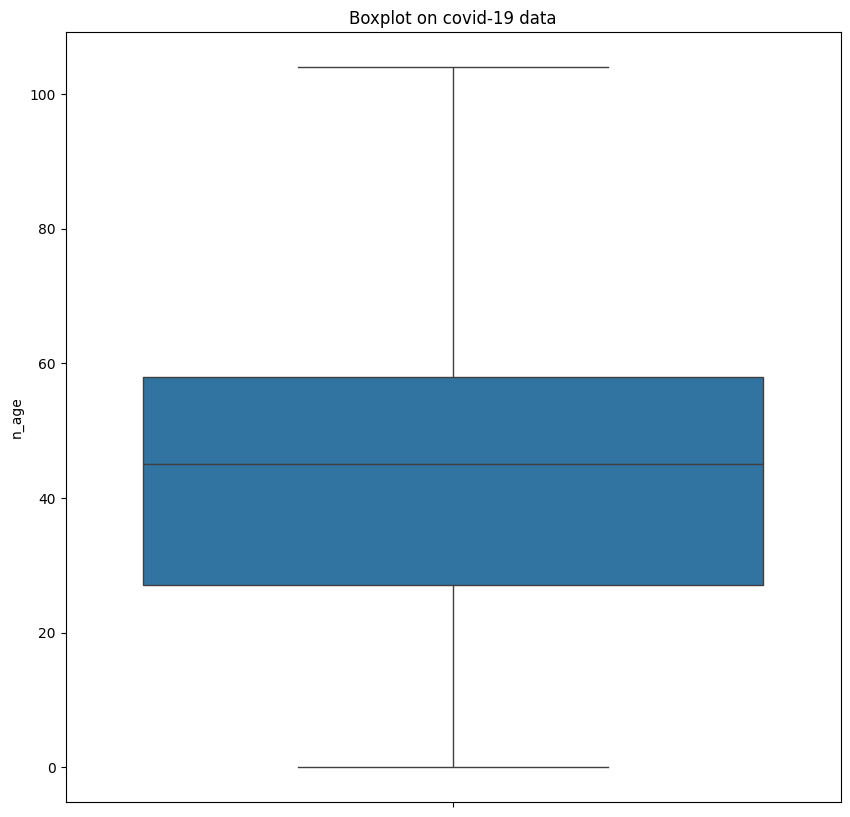

In [103]:


plt.figure(figsize=(10,10))

sns.boxplot(data=df, y='n_age')

plt.title('Boxplot on covid-19 data')

plt.show()

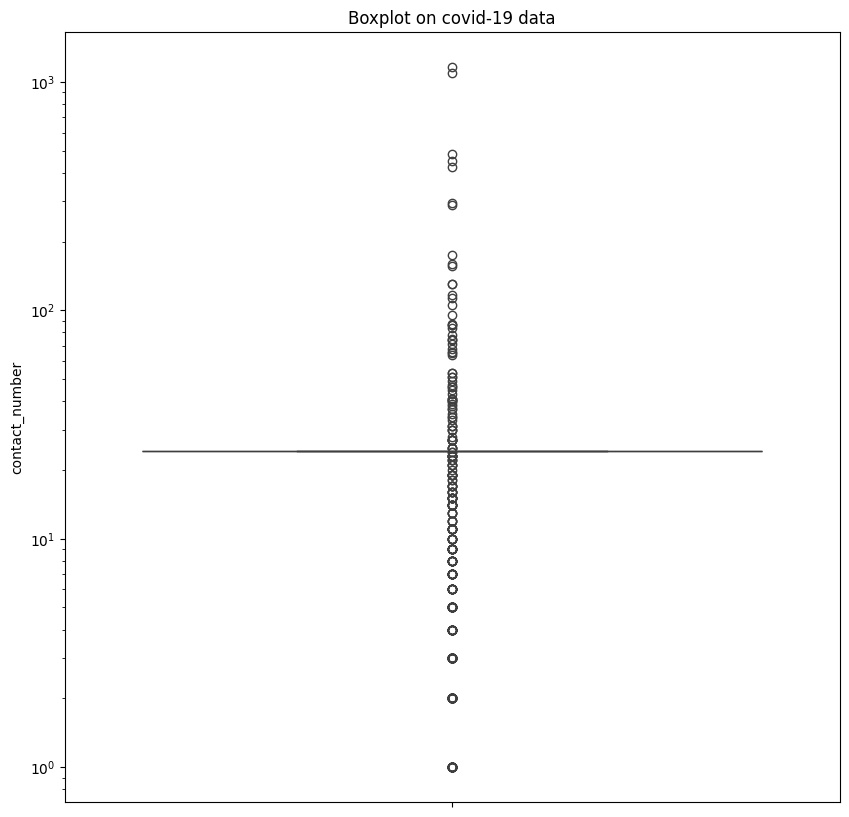

In [112]:
plt.figure(figsize=(10,10))

sns.boxplot(data=df, y='contact_number')


plt.yscale('log') #used log argument to improve visual display 
plt.title('Boxplot on covid-19 data')

plt.show()

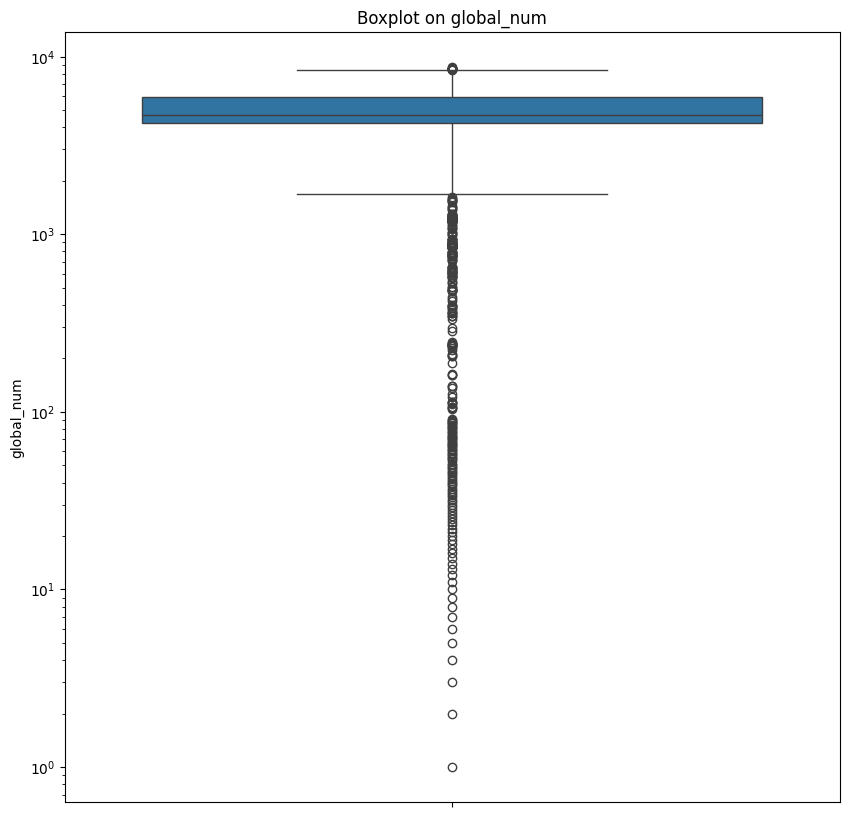

In [111]:
plt.figure(figsize=(10,10))

sns.boxplot(data=df, y='global_num')

plt.yscale('log') #used log argument to improve visual display 
plt.title('Boxplot on global_num')

plt.show()

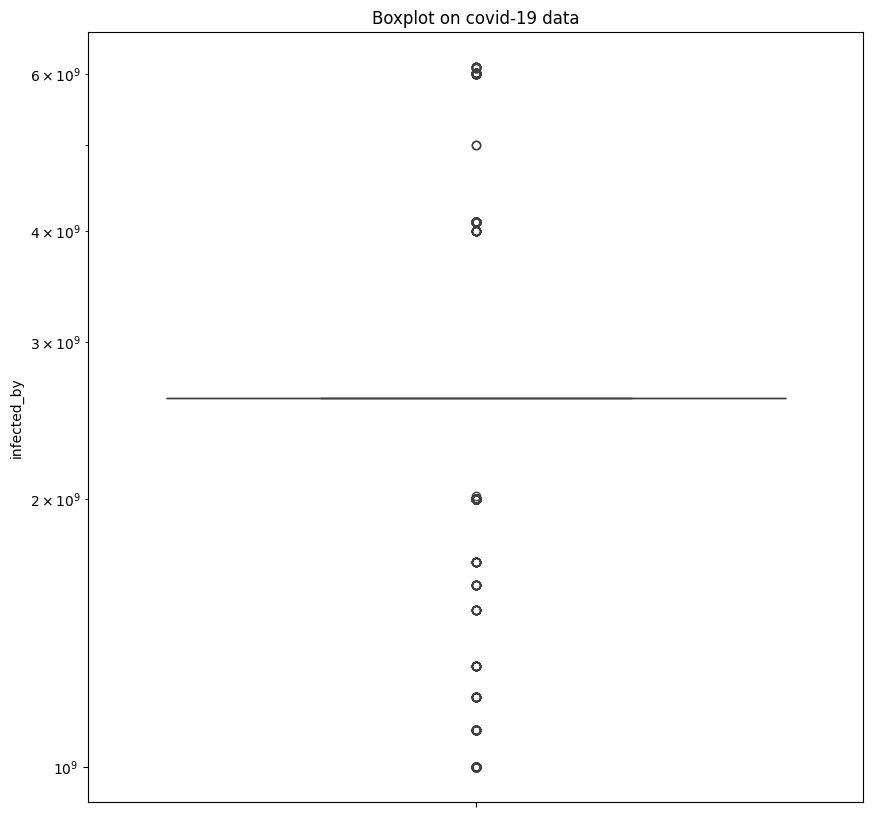

In [109]:
plt.figure(figsize=(10,10))

sns.boxplot(data=df, y='infected_by')

plt.yscale('log') #used log argument to improve visual display 
plt.title('Boxplot on covid-19 data')

plt.show()

**<font color='teal'> Create dummy features for object type features. </font>**

In [113]:
#Check Dtypes

df.dtypes

patient_id           int64
global_num         float64
sex                 object
birth_year         float64
age                 object
country             object
province            object
city                object
disease              int64
infection_case      object
infection_order    float64
infected_by        float64
contact_number     float64
state               object
n_age              float64
dtype: object

In [115]:
#Subset categorical features in case I want to plot them later for further EDA

df_features = df[['state','sex', 'age', 'infection_case','country','province','city','infection_case']]

In [133]:
#Drop target feature 'state' before test_train_split
df_no_state = df.drop('state', axis=1)

In [134]:
#Using One-hot encoding on the categorical features in df.

df_encoded = pd.get_dummies(df_no_state, drop_first=True)

In [135]:
df_encoded.head()

,patient_id,global_num,birth_year,disease,infection_order,infected_by,contact_number,n_age,sex_male,age_100s,...,infection_case_Pilgrimage to Israel,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
0,1000000001,2.0,1964.0,0,1.0,2.600789e+09,75.0,56.0,True,False,...,False,False,False,False,False,False,False,False,False,True
1,1000000002,5.0,1987.0,0,1.0,2.600789e+09,31.0,33.0,True,False,...,False,False,False,False,False,False,False,False,False,True
2,1000000003,6.0,1964.0,0,2.0,2.002000e+09,17.0,56.0,True,False,...,False,False,False,False,False,True,False,False,False,False
3,1000000004,7.0,1991.0,0,1.0,2.600789e+09,9.0,29.0,True,False,...,False,False,False,False,False,False,False,False,False,True
4,1000000005,9.0,1992.0,0,2.0,1.000000e+09,2.0,28.0,False,False,...,False,False,False,False,False,True,False,False,False,False


In [132]:
df['state'].value_counts()

state
isolated    1862
released     324
deceased      32
Name: count, dtype: int64

In [123]:
# Check which columns in df_encoded are related to 'state'
state_columns = [col for col in df_encoded.columns if 'state' in col]
print(state_columns)


['state_isolated', 'state_released']


## Need to define X and y. I need to look at what my target feature and do one last check for bugs!

In [137]:
#df['state'] is target feature or y!

# df_encoded is X, it does not have 'state' since it was dropped. 

X = df_encoded

y = df['state']

### Split the data into test and train subsamples

In [138]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [139]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [140]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [141]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.845
Random Forest: f1-score=0.811


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [142]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  5   2   0]
 [  1 355   8]
 [  0  58  15]]
Normalized confusion matrix
[[0.71 0.29 0.  ]
 [0.   0.98 0.02]
 [0.   0.79 0.21]]


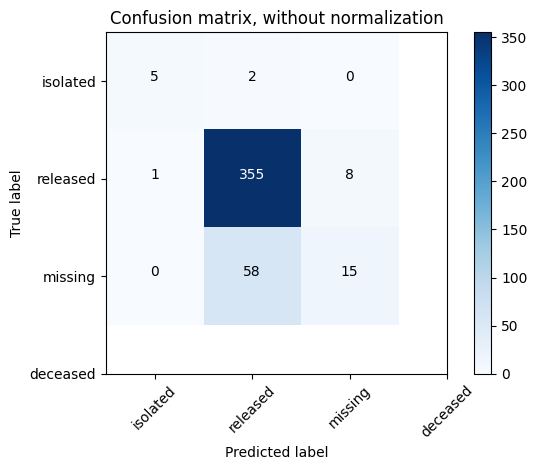

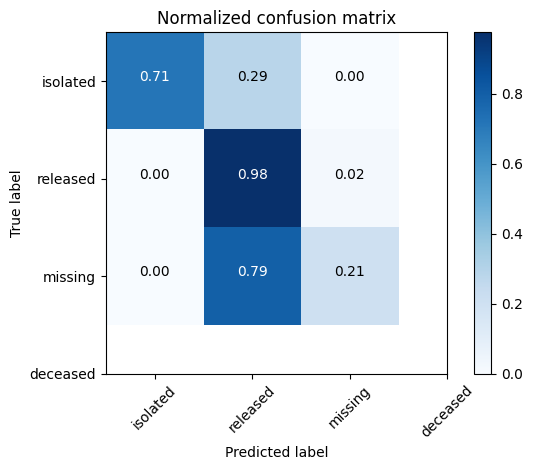

In [143]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


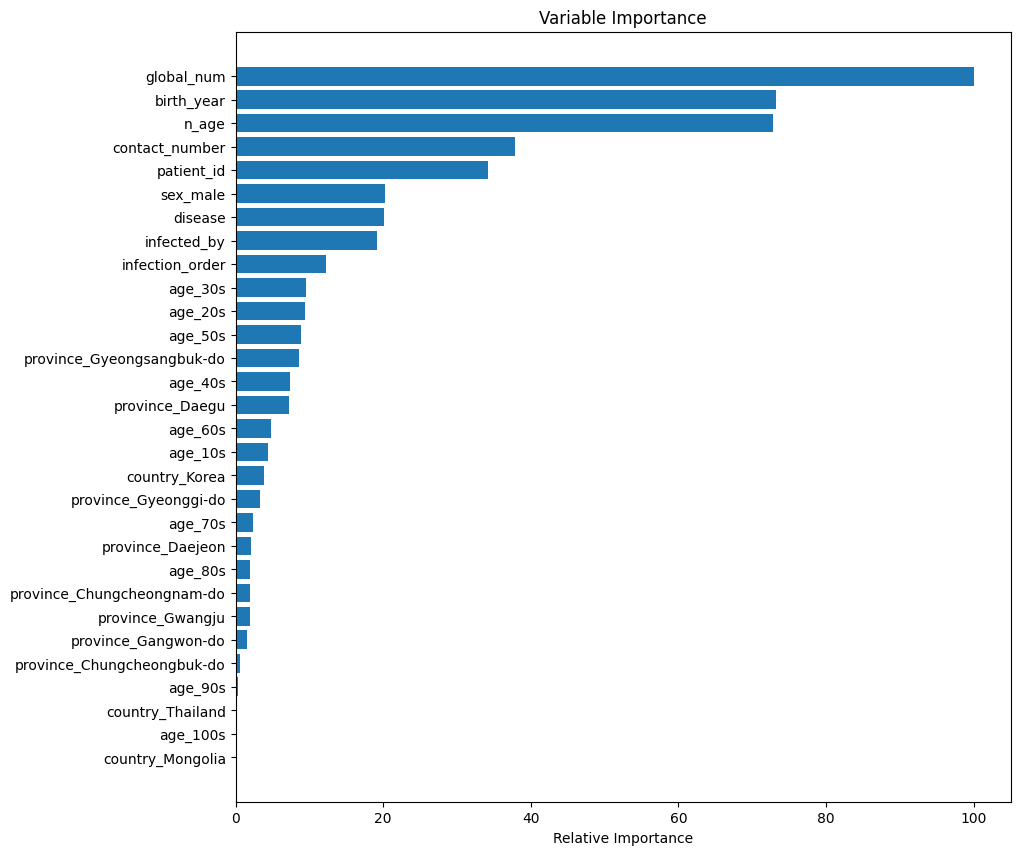

In [144]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.